In [1]:
import pandas as pd
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import MinMaxScaler,Normalizer,StandardScaler,MaxAbsScaler, LabelEncoder

#import graphviz

/home/marcosfabricio/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#Transformando a coluna de sexo de testo pra numero e considerando ela como dado categorico
df = pd.read_csv("abalone_dataset.csv")
df['sex'] = LabelEncoder().fit_transform(df['sex'].tolist())
df['sex'] = df['sex'].astype('category')

In [3]:
# Preprocessamento da base
preps = [MinMaxScaler,Normalizer,StandardScaler,MaxAbsScaler]
# Modelos a serem testados
models = [SVC,LogisticRegression,MLPClassifier,RandomForestClassifier,DecisionTreeClassifier]
# Pipeline para testar todos os modelos com todos os preprocessamento
pipes = [make_pipeline(prepo(),model()) for model in models for prepo in preps]

In [4]:
results = []
for pipe in pipes:
    res = np.median(cross_validate(pipe,df.drop(columns="type"),df["type"],scoring="accuracy",cv=10)["test_score"])
    results.append(np.append(np.array(pipe.steps)[:,0],res))

In [5]:
pd.DataFrame(results,columns=["Preprocessing","Model","Median-Accuracy"]).sort_values(by="Median-Accuracy",ascending=False)

,Preprocessing,Model,Median-Accuracy
6,standardscaler,logisticregression,0.654952
10,standardscaler,mlpclassifier,0.654460
2,standardscaler,svc,0.653904
11,maxabsscaler,mlpclassifier,0.651275
8,minmaxscaler,mlpclassifier,0.645932
9,normalizer,mlpclassifier,0.642169
4,minmaxscaler,logisticregression,0.638404
7,maxabsscaler,logisticregression,0.636807
14,standardscaler,randomforestclassifier,0.626801
5,normalizer,logisticregression,0.620414


# Pegamos o melhor modelo e preprocessamento, para testar no GridSearch

In [6]:
# Pipeline para o grid search
pipe = make_pipeline(StandardScaler(),LogisticRegression())
# Dicionario de parametros a serem testados pelo grid search
parameters = {'logisticregression__penalty':['l2'], 'logisticregression__solver':('newton-cg', 'lbfgs', 'sag', 'saga'), 'logisticregression__C': (np.arange(10,100,10)), 'logisticregression__multi_class':['multinomial'], 'logisticregression__max_iter':[1000]}

In [7]:
# GridSearch com cros validation, testa o modelo com todas as combinações de parametros passadas no dicionario,
# e classifica a melhor de acordo com uma metrica que escolhermos, nesse caso a acuracia.
clf = GridSearchCV(pipe,parameters,scoring="accuracy", cv=10, n_jobs=-1)

In [8]:
%%time
clf.fit(df.drop(columns="type"),df["type"])

CPU times: user 1.35 s, sys: 92.9 ms, total: 1.44 s
Wall time: 53.8 s


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'logisticregression__penalty': ['l2'], 'logisticregression__solver': ('newton-cg', 'lbfgs', 'sag', 'saga'), 'logisticregression__C': array([10, 20, 30, 40, 50, 60, 70, 80, 90]), 'logisticregression__multi_class': ['multinomial'], 'logisticregression__max_iter': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

# Seleção de atributos recursivamente
- selecionamos a melhor combinação de hiperparametros do modelo com o grid search
- aplicamos a seleção de atributos nesse modelo

In [9]:
log = clf.best_estimator_.steps[1][1]

In [10]:
seletor = RFECV(log, cv=10, scoring='accuracy')

In [11]:
seletor.fit(df.drop(columns="type"),df["type"])

RFECV(cv=10,
   estimator=LogisticRegression(C=30, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

In [12]:
#Atributos selecionados
df.drop(columns="type").columns[seletor.get_support()]

Index(['length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
       'viscera_weight', 'shell_weight'],
      dtype='object')

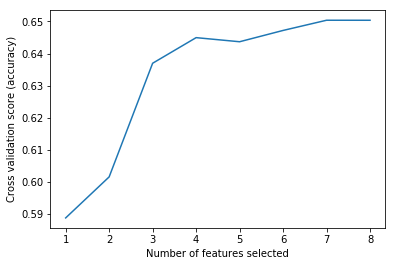

In [13]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(range(1, len(seletor.grid_scores_) + 1), seletor.grid_scores_)
plt.show()

In [14]:
# Gerando vetor resposta pra enviar ao servidor

In [21]:
teste = pd.read_csv("abalone_app.csv")
teste['sex'] = LabelEncoder().fit_transform(teste['sex'].tolist())
teste['sex'] = teste['sex'].astype('category')
base = teste[teste.columns[seletor.get_support()]]

In [23]:
base

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
0,0.600,0.480,0.175,1.2290,0.4125,0.2735,0.4150
1,0.545,0.385,0.150,1.1185,0.5425,0.2445,0.2845
2,0.645,0.520,0.180,1.2850,0.5775,0.3520,0.3170
3,0.640,0.510,0.170,1.3715,0.5670,0.3070,0.4090
4,0.655,0.540,0.215,1.5555,0.6950,0.2960,0.4440
5,0.415,0.300,0.100,0.3355,0.1545,0.0685,0.0950
6,0.235,0.175,0.065,0.0615,0.0205,0.0200,0.0190
7,0.655,0.490,0.160,1.2040,0.5455,0.2615,0.3225
8,0.575,0.450,0.165,0.9215,0.3275,0.2250,0.2560
9,0.550,0.425,0.155,0.9175,0.2775,0.2430,0.3350


In [20]:
pd.Series(seletor.estimator_.predict(base)).to_csv("respostas.csv",index=False)